<br>

# 10 AC SAF Metop-B GOME-2 - NO<sub>2</sub> - Level 3

AC SAF Metop-A/B GOME-2 Level 3 are monthly aggregated products, regridded onto a regular latitude longitude grid, and are disseminated in the data format `netCDF` and are available from the [EUMETSAT Atmospheric Composition Satellite Application Facility (EUMETSAT AC SAF)](https://acsaf.org/). 

This notebook guides you through how the data can be loaded and gives basic plotting examples.

#### Module outline:
* [1 - Load and browse AC SAF Metop-B GOME-2 Level 3 data](#load_l3)
* [2 - Plotting example of AC SAF Metop-B GOME-2 Level 3 data](#plotting)

#### Load required libraries

In [1]:
import sys
!{sys.executable} -m pip install cartopy netCDF4 h5netcdf==1.3.0 satpy==0.51.0 pyhdf h5py python-geotiepoints

In [2]:
import xarray as xr
import pandas as pd

import os 
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Load helper functions

In [3]:
if os.path.exists("functions.ipynb"):
    %run functions.ipynb
elif os.path.exists("../functions.ipynb"):
    %run ../functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")    
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/functions.ipynb
    %run functions.ipynb

In [4]:
if os.path.exists("bucket_functions.ipynb"):
    %run bucket_functions.ipynb
elif os.path.exists("../bucket_functions.ipynb"):
    %run ../bucket_functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")    
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/90_workshops/202410_wmo_school/bucket_functions.ipynb
    %run bucket_functions.ipynb

In [5]:
base_url = 'https://s3.waw3-2.cloudferro.com/swift/v1/wmo/'
all_paths_list = list_data_on_bucket(base_url)
all_paths_list

Status ok



['eodata/',
 'eodata/fci/',
 'eodata/fci/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20240924092245_IDPFI_OPE_20240924092007_20240924092928_N__C_0057_0000/',
 'eodata/fci/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20240924092245_IDPFI_OPE_20240924092007_20240924092928_N__C_0057_0000/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20240925140357_IDPFI_OPE_20240925140007_20240925140023_N__C_0085_0001.nc',
 'eodata/fci/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20240924092245_IDPFI_OPE_20240924092007_20240924092928_N__C_0057_0000/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20240925140408_IDPFI_OPE_20240925140007_20240925140036_N__C_0085_0002.nc',
 'eodata/fci/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20240924092245_IDPFI_OPE_20240924092007_20240924092928_N__C_0057_0000/W_XX-EUMETSAT-Darmstadt,IMG

#### Set geographical extent

In [6]:
latmin = -40
latmax = 10
lonmin = 0
lonmax = 40

<hr>

## <a id="load_l3"></a>Load and browse AC SAF Metop-B GOME-2 Level 3 data

[xarray](http://xarray.pydata.org/en/stable/) is a Python library that makes it easy to load and browse data who are disseminated in the `NetCDF` format.

### Open NetCDF files with `xarray`

#### Open one individual file with `xarray`

By using xarray's `open_dataset()` function, one individual `netCDF` file can be loaded to create a new `xarray.Dataset`. Let us load a Level 3 data file for Nitrogen Dioxide for January 2017 and let us inspect the resulting `xarray.Dataset` and the `latitude` and `longitude` coordinates.

In [7]:
ds = open_data_from_bucket(base_url + 'eodata/gome2/no2/GOME_NO2_L3_202408_METOPB_DLR_v1.nc')
ds, ds.latitude, ds.longitude

File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/no2/GOME_NO2_L3_202408_METOPB_DLR_v1.nc


(<xarray.Dataset> Size: 9kB
 Dimensions:    (lat: 720, lon: 1440)
 Dimensions without coordinates: lat, lon
 Data variables:
     latitude   (lat) float32 3kB ...
     longitude  (lon) float32 6kB ...,
 <xarray.DataArray 'latitude' (lat: 720)> Size: 3kB
 [720 values with dtype=float32]
 Dimensions without coordinates: lat
 Attributes:
     unit:       degree north
     long_name:  latitude of pixel center,
 <xarray.DataArray 'longitude' (lon: 1440)> Size: 6kB
 [1440 values with dtype=float32]
 Dimensions without coordinates: lon
 Attributes:
     unit:       degree east
     long_name:  longitude of pixel center)

<br>

You see that the `data variable` section of the loaded `xarray.Dataset` is empty. This is due to the internal structure of the Metop-A/B GOME-2 Level 3 data. The data is organised in groups within the `netCDF` file. To load from a group, you have to pass the `group='PRODUCT'` as keyword to the `open_dataset()` function. 

If you do this, you can see that the `Dataset` contains six data variables:

* (1) `NO2total`, 
* (2) `NO2total_err`, 
* (3) `NO2total_stddev`, 
* (4) `NO2trop`,
* (5) `NO2trop_err`,
* (6) `NO2trop_stddev`

However, `latitude` and `longitude` do not contain any coordinates.

In [8]:
no2 = open_data_from_bucket(base_url + 'eodata/gome2/no2/GOME_NO2_L3_202408_METOPB_DLR_v1.nc', group='PRODUCT')
no2

File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/no2/GOME_NO2_L3_202408_METOPB_DLR_v1.nc


<xarray.Dataset> Size: 33MB
Dimensions:          (lat: 720, lon: 1440)
Dimensions without coordinates: lat, lon
Data variables:
    no2total         (lat, lon) float32 4MB ...
    no2total_err     (lat, lon) float32 4MB ...
    no2total_stddev  (lat, lon) float32 4MB ...
    no2total_nobs    (lat, lon) float32 4MB ...
    no2trop          (lat, lon) float32 4MB ...
    no2trop_err      (lat, lon) float32 4MB ...
    no2trop_stddev   (lat, lon) float32 4MB ...
    no2trop_nobs     (lat, lon) float32 4MB ...

You can use the xarray function `assign_coords` to assign the coordinate values from your dataset to the dimensions of the `no2` data object.

In [9]:
no2_assigned = no2.assign_coords(latitude=ds.latitude, longitude=ds.longitude)
no2_assigned

<xarray.Dataset> Size: 33MB
Dimensions:          (lat: 720, lon: 1440)
Coordinates:
    latitude         (lat) float32 3kB ...
    longitude        (lon) float32 6kB ...
Dimensions without coordinates: lat, lon
Data variables:
    no2total         (lat, lon) float32 4MB ...
    no2total_err     (lat, lon) float32 4MB ...
    no2total_stddev  (lat, lon) float32 4MB ...
    no2total_nobs    (lat, lon) float32 4MB ...
    no2trop          (lat, lon) float32 4MB ...
    no2trop_err      (lat, lon) float32 4MB ...
    no2trop_stddev   (lat, lon) float32 4MB ...
    no2trop_nobs     (lat, lon) float32 4MB ...

#### Open multiple netCDF files with `xarray`

xarray's `open_mfdataset()` function is very useful to load multiple netCDF files simultaneously. This function automatically concatenates and merges multiple files into a single xarray dataset. The behaviour of `xr.open_mfdataset` is the same as the one of `xr.open_dataset`. In order to access the dataset variables, you have to specify the `group` parameter. 

Additionally, if the dimension you wish to concatenate the individual files on is not defined in the original dataset, a new dimension can be defined by specifying the `concat_dim` key. Let us define `time` as the dimension the files shall be concatenated on.

In [10]:
files = [base_url + path for path in all_paths_list if 'daily/GOME_NO2' in path and path.endswith('.nc')]

datasets = list()
for f in files:
    datasets.append(open_data_from_bucket(f, group='PRODUCT'))

mf_dataset = xr.concat(datasets, dim='time')
mf_dataset

File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/no2/daily/GOME_NO2_L3_20240821_METOPB_DLR_v1.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/no2/daily/GOME_NO2_L3_20240822_METOPB_DLR_v1.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/no2/daily/GOME_NO2_L3_20240823_METOPB_DLR_v1.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/no2/daily/GOME_NO2_L3_20240824_METOPB_DLR_v1.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/no2/daily/GOME_NO2_L3_20240825_METOPB_DLR_v1.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/no2/daily/GOME_NO2_L3_20240826_METOPB_DLR_v1.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/no2/daily/GOME_NO2_L3_20240827_METOPB_DLR_v1.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/no2/daily/GOME_NO2_L3_20240828_METOPB_DLR_v1.nc


<xarray.Dataset> Size: 265MB
Dimensions:          (time: 8, lat: 720, lon: 1440)
Dimensions without coordinates: time, lat, lon
Data variables:
    no2total         (time, lat, lon) float32 33MB nan nan ... 3.958e+15
    no2total_err     (time, lat, lon) float32 33MB nan nan ... 1.527e+14
    no2total_stddev  (time, lat, lon) float32 33MB nan nan ... 7.566e+13
    no2total_nobs    (time, lat, lon) float32 33MB nan nan nan ... 1.53 1.56
    no2trop          (time, lat, lon) float32 33MB nan nan nan ... nan nan nan
    no2trop_err      (time, lat, lon) float32 33MB nan nan nan ... nan nan nan
    no2trop_stddev   (time, lat, lon) float32 33MB nan nan nan ... nan nan nan
    no2trop_nobs     (time, lat, lon) float32 33MB nan nan nan ... nan nan nan

The resulting `xarray.Dataset` has three dimensions (`latitude`, `longitude` and `time`). With `assign_coords` you can assign the right coordinate values to the dimensions. You can use again the `ds` xarray.Dataset you defined at the beginning. 

With the help of Python's [pandas](https://pandas.pydata.org/) library, you can create efficiently a list of monthly time values, which can be assigned to the time dimension.

In [11]:
# Build list of time coordinates with pandas
time_coords = pd.date_range('2024-08-21', '2024-08-28', freq='d').strftime("%Y-%m-%d").tolist()

# Assign values to Dataset dimension
mf_dataset_assigned = mf_dataset.assign_coords(latitude=ds.latitude, longitude=ds.longitude, time=time_coords)
mf_dataset_assigned

<xarray.Dataset> Size: 265MB
Dimensions:          (time: 8, lat: 720, lon: 1440)
Coordinates:
    latitude         (lat) float32 3kB ...
    longitude        (lon) float32 6kB ...
  * time             (time) <U10 320B '2024-08-21' '2024-08-22' ... '2024-08-28'
Dimensions without coordinates: lat, lon
Data variables:
    no2total         (time, lat, lon) float32 33MB nan nan ... 3.958e+15
    no2total_err     (time, lat, lon) float32 33MB nan nan ... 1.527e+14
    no2total_stddev  (time, lat, lon) float32 33MB nan nan ... 7.566e+13
    no2total_nobs    (time, lat, lon) float32 33MB nan nan nan ... 1.53 1.56
    no2trop          (time, lat, lon) float32 33MB nan nan nan ... nan nan nan
    no2trop_err      (time, lat, lon) float32 33MB nan nan nan ... nan nan nan
    no2trop_stddev   (time, lat, lon) float32 33MB nan nan nan ... nan nan nan
    no2trop_nobs     (time, lat, lon) float32 33MB nan nan nan ... nan nan nan

## <a id="plotting"></a>Plotting example of AC SAF Metop-B GOME-2 Level 3 data

The last step is to visualize one time step of the created data object. Since the data are arranged on a regular grid, you can make use of the `pcolormesh` function of Pyton's plotting library [matplotlib](https://matplotlib.org/).

As before, you can make use of Cartopy's features and create a basemap in a `PlateCarree` projection. You can add coast- and gridlines. The NO<sub>2</sub> values are added as colored data values onto a regular grid with matplotlib's `pcolormesh` function. As you might need to re-use the code for plotting, we define a plotting function called [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh).


Let us say, you want to plot the monthly averaged values of `Tropospheric Nitrogen Dioxide` for month August 2024. Before you can visualize it, you have to select the variable `no2trop` from the `xarray.Dataset` *no2_assigned* you defined above.

(<Figure size 2000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'NO2 tropospheric August 2024'}>)

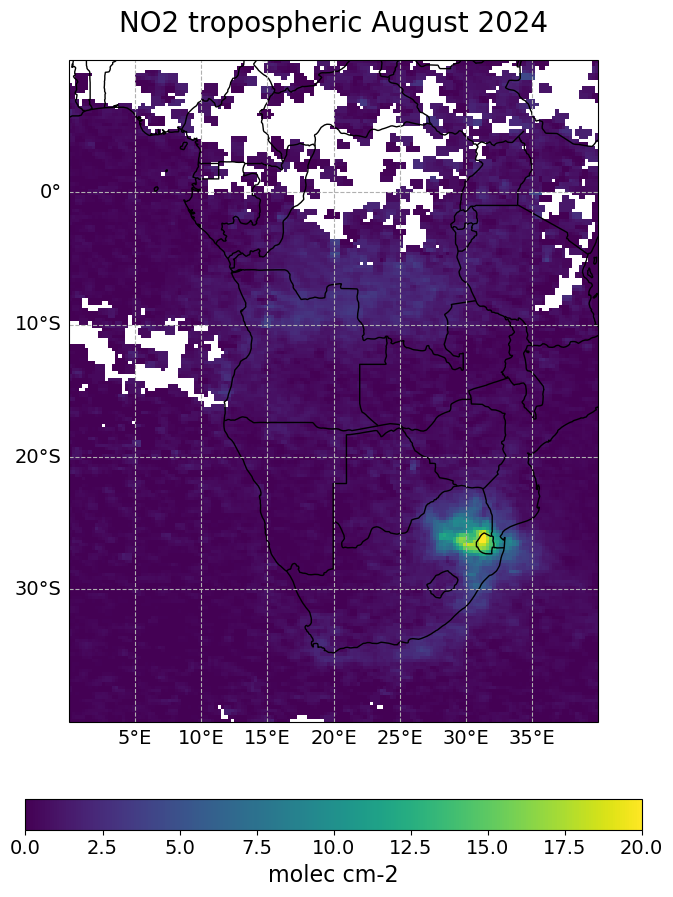

In [12]:
visualize_pcolormesh(data_array=no2_assigned.no2trop*1e-15, 
                     longitude=no2_assigned.longitude, 
                     latitude=no2_assigned.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='viridis', 
                     unit='molec cm-2', 
                     long_name='NO2 tropospheric August 2024', 
                     vmin=0, 
                     vmax=20, 
                     set_global=False,
                     lonmin=lonmin, 
                     lonmax=lonmax, 
                     latmin=latmin, 
                     latmax=latmax, )

Let us say, you want to plot the daily averaged values of `Tropospheric Nitrogen Dioxide` for 21 August 2024. Before you can visualize it, you have to select the variable `no2trop` from the `xarray.Dataset` *mf_dataset_assigned* you defined above and select the day you want to plot.

(<Figure size 2000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'NO2 tropospheric 2024-08-21'}>)

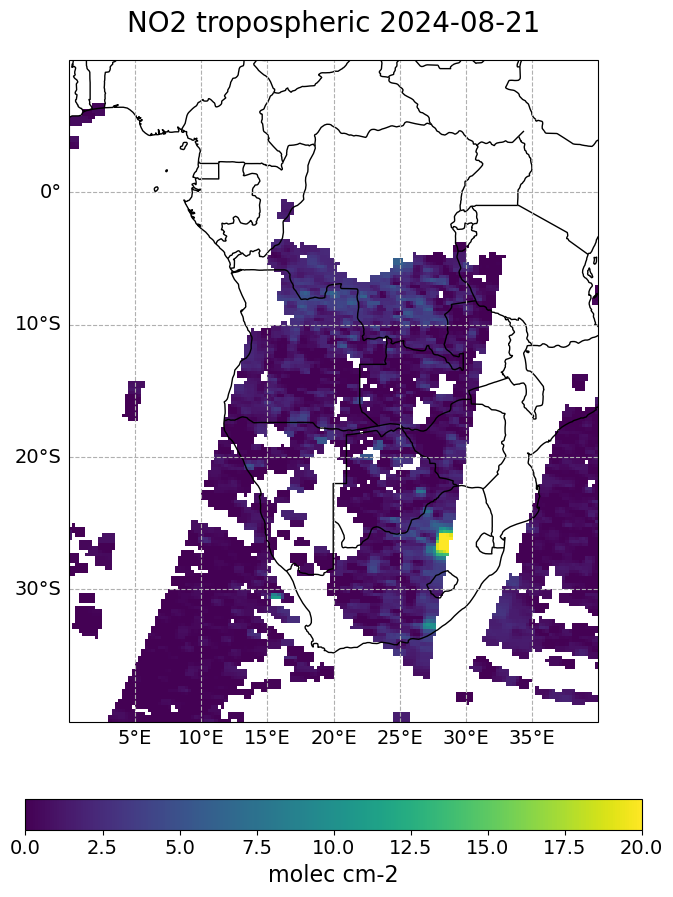

In [13]:
visualize_pcolormesh(data_array=mf_dataset_assigned.no2trop[0]*1e-15, 
                     longitude=mf_dataset_assigned.longitude, 
                     latitude=mf_dataset_assigned.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='viridis', 
                     unit='molec cm-2', 
                     long_name='NO2 tropospheric ' + str(mf_dataset_assigned.time[0].values), 
                     vmin=0, 
                     vmax=20,
                     set_global=False,
                     lonmin=lonmin, 
                     lonmax=lonmax, 
                     latmin=latmin, 
                     latmax=latmax, )


<br>

<hr>

### Resources
This notebook was adapted from: https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/213_Metop-AB_GOME-2_NO2Tropo_L3_load_browse.ipynb?ref_type=heads 

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>